In [62]:
from scipy.optimize import basinhopping
from scipy.integrate import solve_ivp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
from sklearn import linear_model
from scipy.ndimage import uniform_filter

# use moving average to smooth the mobility ratio
def moving_average(a, n=7) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

# return the loss of death increase series & fitted death increase series
def mseloss(y_di, y_dihat):
    # y_d: death increase
    # y_dhat: expected death increase
    return np.sum(np.square(y_dihat - y_di))

# return the mr ratio at time tck
def calc_mr(xnew, tck):
    return interpolate.splev(xnew, tck, der=0)

# time shift optimize
def shape_penalty(x, y): 
    '''
    queries like np.array([[1,2,3,4],[1,2,3,4]]) # 10
    y like np.array([1,3,7,9])
    '''
    
    regr = linear_model.LinearRegression()
    regr.fit(x.T,y.reshape(-1, 1))
    # a, b = regr.coef_, regr.intercept_
    return np.sum(np.square(regr.predict(x.T).reshape(1, -1)-y))

# generating data using given parameters & state values
def gen_data(params, s0, days, initial_exposed=0):
    """
    mr_data: mobility ratio, mr.shape = (1, t)
    queries: queries.shape = (q, t)
    params: parameter: ls[5]
    y_d: real data: y.shape = (1, t)
    """
    # check input
    
    pe = params[0]
    pi = params[1]
    initial_cases = params[2]
    r0 = params[3]
    cfr0 = params[4]
    index = 0
    mr_data = np.ones(days)
    t_tmp = np.linspace(0, days, days)
    tck = interpolate.splrep(t_tmp, mr_data, s=0)
    # [ S, E, I, D, cfr0]
    def rhs(s, v): 
        res = [-r0 * interpolate.splev(s, tck, der=0) * v[0] * v[2]/(pi*s0), 
               r0*v[0]*v[2]/(pi*s0)-v[1]/pe, 
               v[1] / pe - v[2]/pi,
               v[4] * v[2]/pi,
               cfr0 * np.log(0.99)*(0.99**s),
               v[1] / pe]
        return res
    result = solve_ivp(rhs, (0, days), [s0, initial_exposed, initial_cases, 0, cfr0, initial_cases], method='LSODA', t_eval=np.linspace(0,days,days))
    return result

def loss_func(mr_data, queries, params, y_di, lambda0, initial_exposed=0, s0=10000000):
    """
    mr_data: mobility ratio, mr.shape = (1, t)
    queries: queries.shape = (q, t)
    params: [ period of expose, period of infection, number of initial cases, r0, cfr0]: ls[5]
    y_di: real data of death increase: y.shape = (1, t)
    lambda0: float
    initial_exposed: float
    """
    # check input
    pe = params[0]
    pi = params[1]
    initial_cases = params[2]
    r0 = params[3]
    cfr0 = params[4]
    t_tmp = np.linspace(0, len(mr_data), len(mr_data))
    tck = interpolate.splrep(t_tmp, mr_data, s=0)
    # [ S, E, I, D, cfr0, I_increase]
    def rhs(s, v): 
        res = [-r0 * interpolate.splev(s, tck, der=0) * v[0] * v[2]/(pi*s0), 
               r0*v[0]*v[2]/(pi*s0)-v[1]/pe, 
               v[1] / pe - v[2]/pi,
               v[4] * v[2]/pi,
               cfr0 * np.log(0.99)*(0.99**s),
               v[1] / pe]
        return res
    res = solve_ivp(rhs, (0, len(y_di)), [s0, initial_exposed, initial_cases, 0, cfr0, initial_cases], method='LSODA', t_eval=np.linspace(0,len(y_di),len(y_di)))  
    y_dhat = res['y'][3]
    y_dihat = np.diff(y_dhat)
    # calculate shape penalty
    y_iihat = np.append(0, np.diff(res['y'][5]))  
    return mseloss(y_di[1:], y_dihat) + lambda0 * shape_penalty(queries, y_iihat), res




def SA(mr_data, queries, y_di, lambda0, initial_exposed, initial_infected, initial_params=None, tmp=1e4, niter = 10000):
    print('Calculating')
    # [pe, pi, initial_cases, r0, cfr0]
    rands = np.random.uniform(size=niter) 
    cur_loss = float("inf") # Big M
    range_ls = [[3, 5.8], [2.1, 7], [initial_infected, 10 * initial_infected], [1.5, 3], [0.01, 0.4]]
    # initialize parameter
    param_ls = [initial_params[0], initial_params[1], initial_infected, initial_params[3], initial_params[4]] if initial_params else [5.8, 3, initial_infected, 2, 0.4]
    # random initial value 0-10
    for i in range(niter):
        if i%10 == 0:
            print(str(i)+' th iteration',cur_loss)
            tmp *= 0.99
        # pe_range = [4.5, 5.8]
        # pi_range = [2.1, 7]
        # initial_cases_range: change with time
        # r0_range = [2, 2.4]
        # cfr0_range = [0.01, 0.4]
        index = i%5
        new_param = param_ls[:]
        sigma = (range_ls[index][1] - range_ls[index][0])* np.exp(-i/10000)
        epsilon = np.random.normal(0, sigma)
        if param_ls[index] + epsilon >= range_ls[index][0] and param_ls[index] + epsilon <= range_ls[index][1]:
            new_val = param_ls[index] + epsilon
        else:
            new_val = np.random.uniform(range_ls[index][0], range_ls[index][1])
        new_param[index] = new_val
        if loss_func(mr_data, queries, new_param, y_di, lambda0)[0] < cur_loss:
            param_ls = new_param[:]
            cur_loss, all_data = loss_func(mr_data, queries, new_param, y_di, lambda0)
        else:
            u = rands[i]
            if np.exp((cur_loss - loss_func(mr_data, queries, new_param, y_di, lambda0)[0])/tmp) >= u:
                param_ls = new_param[:]
                cur_loss, all_data = loss_func(mr_data, queries, new_param, y_di, lambda0)
    return param_ls, cur_loss, all_data

if __name__ == "__main__":
    # death increase from Jan 22, cut to Mar 1
    # t0: March 1
    # March 15 to March 30
#     t = 14
#     di = pd.read_csv('G:/national-history.csv')['deathIncrease']
#     y_di = np.asarray(di)[38+t:52+t]
#     pi = pd.read_csv('G:/national-history.csv')['positiveIncrease']
#     y_pi = np.asarray(pi)[38+t:52+t]
    
#     positive = 100
#     # query start time: March 1
#     df_queries = pd.read_csv('G:/125/queries.csv')
#     queries = df_queries.to_numpy()[1+t:15+t, 1:].T.astype('float64')
#     queries = uniform_filter(queries, size = 3)
#     # mobility data start time: Feb 15, cut to Mar 1
#     mr_data = np.asarray(pd.read_csv('G:/us_mr.csv')['mr'])
#     mr = mr_data[15+t:29+t]
#     params, loss, predict_data = SA(mr, queries, y_di, lambda0=1, initial_exposed=0, initial_infected=10 * positive)
#     initial_exposed = predict_data['y'][1][-1] 
#     initial_infected = predict_data['y'][2][-1]
    params = [3.619525685150379, 3.558846180493938, 1006.299287675395, 1.5001798351105105, 0.3995021239454605]
    # params = [1, 1, 10000, 1.5001798351105105, 0.3995021239454605]
    initial_exposed = 1500
    initial_infected = 1200
    t = 28
    # April 1 to April 15
    positive = np.asarray(pd.read_csv('G:/national-history.csv')['positive'])[41+t]
    positive = 10000
    y_di = np.asarray(di)[38+t:52+t]
    y_pi = np.asarray(pi)[38+t:52+t]
    queries = df_queries.to_numpy()[1+t:15+t, 1:].T.astype('float64')
    queries = uniform_filter(queries, size = 3)
    mr = mr_data[t+15 : t+29]
    params, loss, predict_data = SA(mr, queries, y_di, lambda0=0, initial_exposed=initial_exposed, initial_infected=positive, initial_params=params)
    print(params)

Calculating
0 th iteration inf
10 th iteration 1095778.334907562
20 th iteration 948905.502087078
30 th iteration 948905.502087078
40 th iteration 948905.502087078
50 th iteration 948905.502087078
60 th iteration 948905.502087078
70 th iteration 948905.502087078
80 th iteration 950496.7679994348
90 th iteration 950496.7679994348
100 th iteration 933217.8094171989
110 th iteration 933217.8094171989
120 th iteration 905326.0431331199
130 th iteration 906392.6205480442
140 th iteration 906392.6205480442
150 th iteration 906392.6205480442
160 th iteration 906392.6205480442
170 th iteration 906392.6205480442
180 th iteration 906392.6205480442
190 th iteration 906392.6205480442
200 th iteration 900294.1943857338
210 th iteration 900294.1943857338
220 th iteration 900294.1943857338
230 th iteration 900294.1943857338
240 th iteration 900294.1943857338
250 th iteration 900294.1943857338
260 th iteration 900294.1943857338
270 th iteration 903998.6107460614
280 th iteration 903998.6107460614
290 

2320 th iteration 858506.6145634791
2330 th iteration 858506.6145634791
2340 th iteration 858506.6145634791
2350 th iteration 858506.6145634791
2360 th iteration 858506.6145634791
2370 th iteration 857837.7850608018
2380 th iteration 857837.7850608018
2390 th iteration 857837.7850608018
2400 th iteration 857837.7850608018
2410 th iteration 857837.7850608018
2420 th iteration 857837.7850608018
2430 th iteration 857769.3754100853
2440 th iteration 857769.3754100853
2450 th iteration 857769.3754100853
2460 th iteration 857769.3754100853
2470 th iteration 857769.3754100853
2480 th iteration 857769.3754100853
2490 th iteration 857769.3754100853
2500 th iteration 857769.3754100853
2510 th iteration 857769.3754100853
2520 th iteration 857769.3754100853
2530 th iteration 857769.3754100853
2540 th iteration 857769.3754100853
2550 th iteration 853978.7125678675
2560 th iteration 853978.7125678675
2570 th iteration 853978.7125678675
2580 th iteration 853978.7125678675
2590 th iteration 853978.712

4620 th iteration 827973.6845655756
4630 th iteration 827973.6845655756
4640 th iteration 827973.6845655756
4650 th iteration 827973.6845655756
4660 th iteration 827973.6845655756
4670 th iteration 827973.6845655756
4680 th iteration 827973.6845655756
4690 th iteration 827973.6845655756
4700 th iteration 827973.6845655756
4710 th iteration 826661.8017267653
4720 th iteration 826661.8017267653
4730 th iteration 824984.2116281551
4740 th iteration 824919.7236150168
4750 th iteration 824919.7236150168
4760 th iteration 824919.7236150168
4770 th iteration 824919.7236150168
4780 th iteration 821602.0370213081
4790 th iteration 821602.0370213081
4800 th iteration 821602.0370213081
4810 th iteration 821602.0370213081
4820 th iteration 821602.0370213081
4830 th iteration 821602.0370213081
4840 th iteration 821602.0370213081
4850 th iteration 821602.0370213081
4860 th iteration 821602.0370213081
4870 th iteration 821602.0370213081
4880 th iteration 821602.0370213081
4890 th iteration 820764.426

6970 th iteration 806894.3028290789
6980 th iteration 806894.3028290789
6990 th iteration 806894.3028290789
7000 th iteration 806894.3028290789
7010 th iteration 806834.9130333327
7020 th iteration 806834.9130333327
7030 th iteration 806834.9130333327
7040 th iteration 806837.0614866349
7050 th iteration 806837.0614866349
7060 th iteration 806837.0614866349
7070 th iteration 806837.0614866349
7080 th iteration 806837.0614866349
7090 th iteration 806837.0614866349
7100 th iteration 806837.0614866349
7110 th iteration 806837.0614866349
7120 th iteration 806837.0614866349
7130 th iteration 806837.0614866349
7140 th iteration 806837.0614866349
7150 th iteration 806837.0614866349
7160 th iteration 806837.0614866349
7170 th iteration 806837.0614866349
7180 th iteration 806837.0614866349
7190 th iteration 806837.0614866349
7200 th iteration 806837.0614866349
7210 th iteration 806837.0614866349
7220 th iteration 806837.0614866349
7230 th iteration 806837.0614866349
7240 th iteration 806837.061

9270 th iteration 802968.5188122957
9280 th iteration 802968.5188122957
9290 th iteration 802968.5188122957
9300 th iteration 802968.5188122957
9310 th iteration 802968.5188122957
9320 th iteration 802968.5188122957
9330 th iteration 802968.5188122957
9340 th iteration 802968.5188122957
9350 th iteration 802968.5188122957
9360 th iteration 802968.5188122957
9370 th iteration 802968.5188122957
9380 th iteration 802968.5188122957
9390 th iteration 802968.5188122957
9400 th iteration 802968.5188122957
9410 th iteration 802968.5188122957
9420 th iteration 802968.5188122957
9430 th iteration 802968.5188122957
9440 th iteration 802146.2994761185
9450 th iteration 802146.2994761185
9460 th iteration 802096.5848634577
9470 th iteration 802096.5848634577
9480 th iteration 802096.5848634577
9490 th iteration 802096.5848634577
9500 th iteration 802096.5848634577
9510 th iteration 802096.5848634577
9520 th iteration 802096.5848634577
9530 th iteration 801747.6824229207
9540 th iteration 801747.682

In [52]:
params

[3.619525685150379,
 3.558846180493938,
 1006.299287675395,
 1.5001798351105105,
 0.3995021239454605]

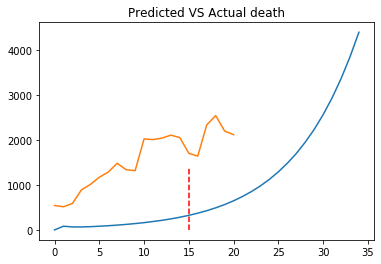

In [31]:
params = [3.0072797223572874, 2.1040981010606328, 508.57360949443205, 1.8732413032047235, 0.3999277959993581]
fitted = gen_data(params, s0=10000000, days=35)
deathincrease = np.append(0, np.diff(fitted['y'][3]))
positiveincrease = np.append(0, np.diff(fitted['y'][2]))
plt.plot(deathincrease)
plt.plot(np.asarray(di)[66:87])
plt.title('Predicted VS Actual death')
plt.vlines(15, 0, 1400, colors = "red", linestyles = "dashed")

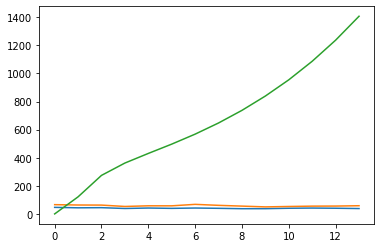

In [30]:
plt.plot(queries[0])
plt.plot(queries[1])
plt.plot(np.append(0, np.diff(predict_data['y'][5])))

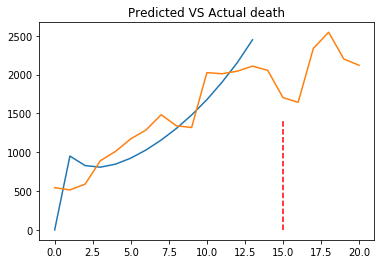

In [63]:
deathincrease = np.append(0, np.diff(predict_data['y'][3]))
positiveincrease = np.append(0, np.diff(fitted['y'][2]))
plt.plot(deathincrease)
plt.plot(np.asarray(di)[66:87])
plt.title('Predicted VS Actual death')
plt.vlines(15, 0, 1400, colors = "red", linestyles = "dashed")

In [25]:
np.asarray(pd.read_csv('G:/national-history.csv')['positive'])[55]

10358

In [42]:
predict_data

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 69
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([ 0.        ,  1.07692308,  2.15384615,  3.23076923,  4.30769231,
        5.38461538,  6.46153846,  7.53846154,  8.61538462,  9.69230769,
       10.76923077, 11.84615385, 12.92307692, 14.        ])
 t_events: None
        y: array([[1.00000000e+07, 9.99958875e+06, 9.99926369e+06, 9.99894712e+06,
        9.99860598e+06, 9.99822249e+06, 9.99778155e+06, 9.99728943e+06,
        9.99674086e+06, 9.99609284e+06, 9.99532861e+06, 9.99442036e+06,
        9.99337164e+06, 9.99217415e+06],
       [0.00000000e+00, 3.59338601e+02, 5.56632209e+02, 7.04404250e+02,
        8.46842928e+02, 1.00259285e+03, 1.18112252e+03, 1.38946413e+03,
        1.63401498e+03, 1.92138798e+03, 2.25877651e+03, 2.65581793e+03,
        3.12094553e+03, 3.66785188e+03],
       [5.01404859e+02, 3.53065006e+02, 3.26736625e+02, 3.51124627e+02,
     

[[ 35.88566901  20.51359945  11.65930449  18.07343138   9.10919108
    7.09891806  17.68630944  23.75190604  35.56398933  17.71654511
   28.6445167   35.66678954  49.24674438  51.66023518  64.14756949
   29.26936312  62.5026506   59.11965232  57.39041921  49.73704627
   49.91629988  71.3474066   35.12146892  44.35864701  44.53218653
   78.93224157  39.68522397  64.99605307  61.25807871  53.32007955]
 [ 11.89691172   5.89140599  26.36844409   6.05713711  18.30690266
   14.2665847   14.10775134  26.9129756   23.87087995  11.88820906
   20.14169284  14.96081887  35.38371648  41.5544735   23.44848008
   38.28965641  41.8678057   80.29253272  60.57260926  79.98415063
  234.1796641  521.6199187  426.9457476  398.4728398  262.7789258
  291.974321   309.1368113  225.4512687  201.6169232  174.9480482 ]]


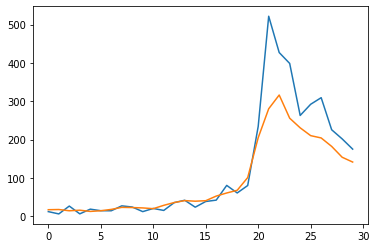

In [20]:
import pandas as pd
from scipy.ndimage import uniform_filter
import matplotlib.pyplot as plt

df_queries = pd.read_csv('G:/125/queries.csv')
queries = df_queries.to_numpy()[1:31, 1:].T.astype('float64')
print(queries)
q2 = uniform_filter(queries, size = 3)
plt.plot(queries[1])
plt.plot(q2[1])

In [66]:
y = np.append(0, np.diff(predict_data['y'][5])
regr = linear_model.LinearRegression()
regr.fit(queries.T,y.reshape(-1, 1))
plt.plot(regr.predict(x.T))
plt.plot(y)

SyntaxError: invalid syntax (<ipython-input-66-767ee87762cc>, line 2)

In [28]:
import numpy as np
q=[1,2,4]
np.concatenate((np.asarray(q[0]), np.diff(q,1)))

ValueError: zero-dimensional arrays cannot be concatenated